In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
import string
from nltk.corpus import stopwords
from sklearn.neighbors import NearestNeighbors
import re

%matplotlib inline

## READ IN BAGEL RESTAURANT DATA FOR NYC AND MTL

### STEP 1:
    - CLEAN THE DATA
    - EXPLORE:
        - NUMBER OF REVIEWS BY RATING
        - REVIEW-TEXT DISTRIBUTION - CREATE HISTOGRAM OF LENGHT OF REVIEWS (DO ALL STAR RATINGS CONSIST OF THE SAME DISTRIBUTION FOR SHORT, LONG AND MEDIUM-LENGTH REVIEWS?
        - SENTIMENT POLARITY DISTRIBUTION OF THE REVIEWS
        - EXAMINE IF THERE ARE BEHAVIOURAL DIFFERENCES BETWEEN HOW LOCALS AND TOURISTS RATE AND REVIEW
        - VISUALIZE WORLD MAP OF CUSTOMER LOCATIONS (OR OTHER METHOD)
        
### STEP 2:
    - DEFINE MEASUREMNTS:
        - DETERMINE HEURISTIC FOR DECIDING WHICH CITY HAS BETTER BAGELS
        - DETERMINE HOW TO ADJUST FOR POPULATION & NUMBER OF REVIEWS FOR EACH CITY
        - Negative / Positive Ratio distribution of ratings
        - Locals / Non-Locals positive/negative distribution of ratings
        - 

### STEP 3:
    - SENTIMENT ANALYSIS:
        - Upsample the negative reviews
        - BAG-OF-WORDS ON THE REVIEW DATA
        - FITTING A CLASSIFIER
        - STEMMING & LEMMATIZATION 
        - TF-IDF VECTORIZATION
        - TOPIC MODELLING (LDA)
        - LOGISTIC REGRESSION IN PYTORCH
        - FEED FORWARD NEURAL NETWORK IN PYTORCH
        - CNN IN PYTORCH

In [2]:
mtl_full = pd.read_csv('data/mtl_bagels_full.csv')
nyc_full = pd.read_csv('data/nyc_bagels_full.csv')

## DROP COLUMNS

In [3]:
# Drop columns we don't need
mtl_full.drop(columns=['web-scraper-order', 'web-scraper-start-url', 'listing-pagination-next',
       'listing-pagination-next-href', 'yelp-link-href', 'review-pagination', 'review-pagination-href'], inplace=True)

# Drop columns we don't need
nyc_full.drop(columns=['web-scraper-order', 'web-scraper-start-url', 'listing-pagination-next',
       'listing-pagination-next-href', 'yelp-link-href', 'review-pagination', 'review-pagination-href'], inplace=True)

In [4]:
mtl_full.head()

,yelp-link,customer-name,customer-location,review-text,review-rating,review-date
0,De Farine et d’Eau Fraîche,Jedsada Y.,"Astoria, Queens, NY",I always stop by DFEF for my morning fix every...,5 star rating,1/3/2017
1,Second Cup,Peter G.,"Boston, MA",It's 8am on a Sunday in Montreal. The streets ...,4 star rating,6/24/2009
2,Cora,Kathleen H.,"Toronto, Canada",This is probably one of my favourite places I'...,4 star rating,3/18/2019
3,Café Castel,Desmond T.,"Queens, Queens, NY",So we walked all the way here with high hopes ...,1 star rating,7/2/2018
4,L’Oeufrier,Leo L.,"Montreal, Canada",Came here for brunch with some friends. This s...,4 star rating,12/28/2018


## RENAME COLUMNS

In [5]:
# Rename columns
nyc_full.rename(columns={'yelp-link': 'res_name', 'review-rating': 'rating', 'customer-location': 'cus_location',
                        'review-text': 'text', 'review-date': 'date', 'customer-name': 'cus_name'}, inplace=True)
nyc_full.head()

,res_name,cus_name,cus_location,text,rating,date
0,Juliano Gourmet Coffee,Brian C.,"Manhattan, NY",TERRIBLE! TERRIBLE! Worst customer service eve...,1 star rating,11/2/2019
1,II Caffe Latte 2,Lenis M.,"Bronx, New York, NY",Rudest and unprofessional workers ever \nI wou...,1 star rating,12/3/2019
2,Russ & Daughters at the Jewish Museum - Temp. ...,Julie F.,"Pompano Beach, FL",We came to the museum to see the Leonard Cohen...,3 star rating,5/17/2019
3,Butterfield Market,Ellen J.,"New York, NY",Definitely pricey but it's every dessert-lover...,4 star rating,4/16/2021
4,Wu & Nussbaum,Adam F.,"New York, NY",We like to get egg and cheese bagels here on t...,5 star rating,9/22/2020


In [6]:
# Rename columns
mtl_full.rename(columns={'yelp-link': 'res_name', 'review-rating': 'rating', 'customer-location': 'cus_location',
                        'review-text': 'text', 'review-date': 'date', 'customer-name': 'cus_name'}, inplace=True)
mtl_full.head()

,res_name,cus_name,cus_location,text,rating,date
0,De Farine et d’Eau Fraîche,Jedsada Y.,"Astoria, Queens, NY",I always stop by DFEF for my morning fix every...,5 star rating,1/3/2017
1,Second Cup,Peter G.,"Boston, MA",It's 8am on a Sunday in Montreal. The streets ...,4 star rating,6/24/2009
2,Cora,Kathleen H.,"Toronto, Canada",This is probably one of my favourite places I'...,4 star rating,3/18/2019
3,Café Castel,Desmond T.,"Queens, Queens, NY",So we walked all the way here with high hopes ...,1 star rating,7/2/2018
4,L’Oeufrier,Leo L.,"Montreal, Canada",Came here for brunch with some friends. This s...,4 star rating,12/28/2018


In [7]:
mtl_full_head = mtl_full.head()

In [8]:
mtl_full_head.to_csv('mtl_full_head.csv')

### CHECK SHAPE

In [13]:
print(f'We have {mtl_full.shape[0]} rows and {mtl_full.shape[1]} columns of data in mtl_full')
print(f'We have {nyc_full.shape[0]} rows and {nyc_full.shape[1]} columns of data in nyc_full')

We have 3071 rows and 6 columns of data in mtl_full
We have 4217 rows and 6 columns of data in nyc_full


## CHECK FOR DUPLICATES

In [15]:
# review_text will be the unique column

mtl_full['text'].value_counts

<bound method IndexOpsMixin.value_counts of 0       I always stop by DFEF for my morning fix every...
1       It's 8am on a Sunday in Montreal. The streets ...
2       This is probably one of my favourite places I'...
3       So we walked all the way here with high hopes ...
4       Came here for brunch with some friends. This s...
                              ...                        
3066    Found out about this bakery on Instagram, and ...
3067    I've been to this location 3 times and I've ha...
3068    Whenever I breeze through Dorval Airport (er, ...
3069    Came here directly after arriving from the air...
3070    Came for brunch and was extremely impressed! I...
Name: text, Length: 3071, dtype: object>

Great - it looks like we don't have any duplicates. How about NYC?

In [16]:
# checking duplicates for NYC
# expecting 4217 unique values, as that's the number of rows in the dataframe
# remember - each row holds 1 review! 

nyc_full['text'].value_counts

<bound method IndexOpsMixin.value_counts of 0       TERRIBLE! TERRIBLE! Worst customer service eve...
1       Rudest and unprofessional workers ever \nI wou...
2       We came to the museum to see the Leonard Cohen...
3       Definitely pricey but it's every dessert-lover...
4       We like to get egg and cheese bagels here on t...
                              ...                        
4212    With the closing of my old bagel standby (Bage...
4213    Been waiting for Bambu near me to open and it'...
4214    This is the cutest family bakery! If you're lo...
4215    The my are open again, got my pastrami fix!! S...
4216    Want to go to hamburger heaven?  Then this is ...
Name: text, Length: 4217, dtype: object>

Great - no duplicates. How about null values?

## CHECK FOR NULL VALUES

In [17]:
print(nyc_full.isna().sum())
print(mtl_full.isna().sum())

res_name        0
cus_name        0
cus_location    2
text            0
rating          0
date            0
dtype: int64
res_name        0
cus_name        2
cus_location    0
text            0
rating          0
date            0
dtype: int64


In [18]:
# Delete the 2 nulls in each df
mtl_full = mtl_full[mtl_full['cus_name'].notna()]
nyc_full = nyc_full[nyc_full['cus_location'].notna()]

In [19]:
# verify
print(nyc_full.isna().sum())
print(mtl_full.isna().sum())

res_name        0
cus_name        0
cus_location    0
text            0
rating          0
date            0
dtype: int64
res_name        0
cus_name        0
cus_location    0
text            0
rating          0
date            0
dtype: int64


In [20]:
nyc_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4215 entries, 0 to 4216
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   res_name      4215 non-null   object
 1   cus_name      4215 non-null   object
 2   cus_location  4215 non-null   object
 3   text          4215 non-null   object
 4   rating        4215 non-null   object
 5   date          4215 non-null   object
dtypes: object(6)
memory usage: 230.5+ KB


Let's convert:

- review_date to datetime

- cus_rating to int, then binarize


## DATA TYPE CONVERSIONS

In [22]:
mtl_full['rating'].head()

0    5 star rating
1    4 star rating
2    4 star rating
3    1 star rating
4    4 star rating
Name: rating, dtype: object

### MTL

In [24]:
# assign column 0 back to dataframe

cols = mtl_full['rating'].str.split(' ', expand=True)

mtl_full['rating'] = cols[0]

mtl_full.head()

<ipython-input-24-f1622e83c0f8>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mtl_full['rating'] = cols[0]


,res_name,cus_name,cus_location,text,rating,date
0,De Farine et d’Eau Fraîche,Jedsada Y.,"Astoria, Queens, NY",I always stop by DFEF for my morning fix every...,5,1/3/2017
1,Second Cup,Peter G.,"Boston, MA",It's 8am on a Sunday in Montreal. The streets ...,4,6/24/2009
2,Cora,Kathleen H.,"Toronto, Canada",This is probably one of my favourite places I'...,4,3/18/2019
3,Café Castel,Desmond T.,"Queens, Queens, NY",So we walked all the way here with high hopes ...,1,7/2/2018
4,L’Oeufrier,Leo L.,"Montreal, Canada",Came here for brunch with some friends. This s...,4,12/28/2018


In [25]:
# make rating into a numeric
mtl_full['rating'] = pd.to_numeric(mtl_full['rating'])

<ipython-input-25-89285cce5cf3>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mtl_full['rating'] = pd.to_numeric(mtl_full['rating'])


In [26]:
mtl_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3069 entries, 0 to 3070
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   res_name      3069 non-null   object
 1   cus_name      3069 non-null   object
 2   cus_location  3069 non-null   object
 3   text          3069 non-null   object
 4   rating        3069 non-null   int64 
 5   date          3069 non-null   object
dtypes: int64(1), object(5)
memory usage: 167.8+ KB


In [27]:
# convert review-date to datetime object

mtl_full['date'] = pd.to_datetime(mtl_full['date'])
mtl_full.head()

<ipython-input-27-02dbb2374f03>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mtl_full['date'] = pd.to_datetime(mtl_full['date'])


,res_name,cus_name,cus_location,text,rating,date
0,De Farine et d’Eau Fraîche,Jedsada Y.,"Astoria, Queens, NY",I always stop by DFEF for my morning fix every...,5,2017-01-03
1,Second Cup,Peter G.,"Boston, MA",It's 8am on a Sunday in Montreal. The streets ...,4,2009-06-24
2,Cora,Kathleen H.,"Toronto, Canada",This is probably one of my favourite places I'...,4,2019-03-18
3,Café Castel,Desmond T.,"Queens, Queens, NY",So we walked all the way here with high hopes ...,1,2018-07-02
4,L’Oeufrier,Leo L.,"Montreal, Canada",Came here for brunch with some friends. This s...,4,2018-12-28


### NYC

In [28]:
# assign column 0 back to dataframe

cols = nyc_full['rating'].str.split(' ', expand=True)

nyc_full['rating'] = cols[0]

nyc_full.head()

,res_name,cus_name,cus_location,text,rating,date
0,Juliano Gourmet Coffee,Brian C.,"Manhattan, NY",TERRIBLE! TERRIBLE! Worst customer service eve...,1,11/2/2019
1,II Caffe Latte 2,Lenis M.,"Bronx, New York, NY",Rudest and unprofessional workers ever \nI wou...,1,12/3/2019
2,Russ & Daughters at the Jewish Museum - Temp. ...,Julie F.,"Pompano Beach, FL",We came to the museum to see the Leonard Cohen...,3,5/17/2019
3,Butterfield Market,Ellen J.,"New York, NY",Definitely pricey but it's every dessert-lover...,4,4/16/2021
4,Wu & Nussbaum,Adam F.,"New York, NY",We like to get egg and cheese bagels here on t...,5,9/22/2020


In [29]:
# make rating into a numeric
nyc_full['rating'] = pd.to_numeric(nyc_full['rating'])

In [31]:
# convert review_date to datetime object

nyc_full['date'] = pd.to_datetime(nyc_full['date'])
nyc_full.head()

,res_name,cus_name,cus_location,text,rating,date
0,Juliano Gourmet Coffee,Brian C.,"Manhattan, NY",TERRIBLE! TERRIBLE! Worst customer service eve...,1,2019-11-02
1,II Caffe Latte 2,Lenis M.,"Bronx, New York, NY",Rudest and unprofessional workers ever \nI wou...,1,2019-12-03
2,Russ & Daughters at the Jewish Museum - Temp. ...,Julie F.,"Pompano Beach, FL",We came to the museum to see the Leonard Cohen...,3,2019-05-17
3,Butterfield Market,Ellen J.,"New York, NY",Definitely pricey but it's every dessert-lover...,4,2021-04-16
4,Wu & Nussbaum,Adam F.,"New York, NY",We like to get egg and cheese bagels here on t...,5,2020-09-22


## NUMBER OF REVIEWS BY RATING

### MTL

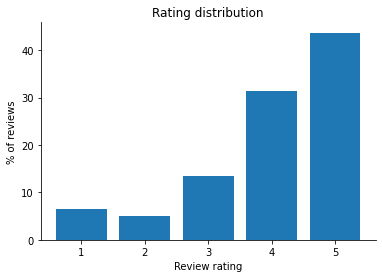

In [32]:
# Plot out number of reviews for each rating 1-5

values, counts = np.unique(mtl_full['rating'], return_counts=True)
normalized_counts = counts/counts.sum()

plt.figure()
plt.bar(values, normalized_counts * 100)
plt.xlabel('Review rating')
plt.ylabel('% of reviews')
sns.despine()
plt.title("Rating distribution")
plt.show()

### NYC

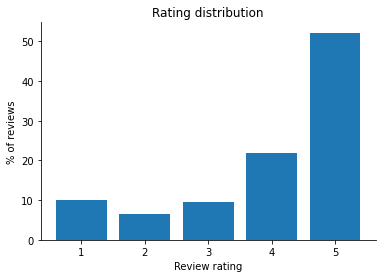

In [33]:
# Plot out number of reviews for each rating 1-5

values, counts = np.unique(nyc_full['rating'], return_counts=True)
normalized_counts = counts/counts.sum()

plt.figure()
plt.bar(values, normalized_counts * 100)
plt.xlabel('Review rating')
plt.ylabel('% of reviews')
sns.despine()
plt.title("Rating distribution")
plt.show()

I was expecting to see this kind of distribution. What about the actual counts?

In [34]:
# value counts + total # of reviews
print(f'Review rating count for Montreal dataset: \n\
.......\n\
{mtl_full["rating"].value_counts()}')

print(f'Total number of unique reviews for Montreal dataset: \n\
.......\n\
{mtl_full["rating"].value_counts().sum()}')



Review rating count for Montreal dataset: 
.......
5    1341
4     963
3     414
1     199
2     152
Name: rating, dtype: int64
Total number of unique reviews for Montreal dataset: 
.......
3069


In [35]:
# value counts + total # of reviews
print(f'Review rating count for New York City dataset: \n\
.......\n\
{nyc_full["rating"].value_counts()}')

print(f'Total number of unique reviews for New York City dataset: \n\
.......\n\
{nyc_full["rating"].value_counts().sum()}')



Review rating count for New York City dataset: 
.......
5    2198
4     922
1     418
3     405
2     272
Name: rating, dtype: int64
Total number of unique reviews for New York City dataset: 
.......
4215


## REVIEW-TEXT DISTRIBUTION

#### MTL

In [36]:
mtl_full['review_length'] = mtl_full['text'].map(len)

[Text(3.674999999999997, 0.5, 'Number of reviews')]

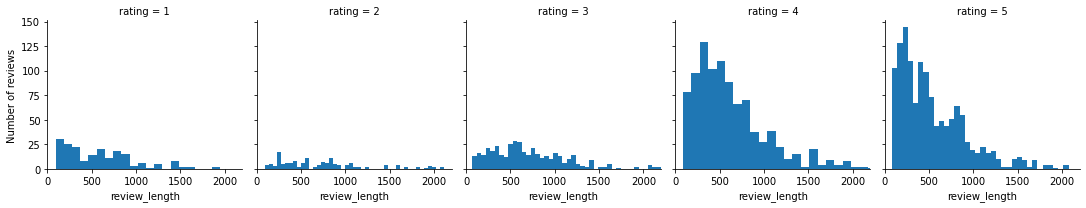

In [37]:
# Check how the review lenghts are distributed
ax = sns.FacetGrid(data=mtl_full, col='rating', xlim=(0,2200)).map(plt.hist, 'review_length', bins=50)
ax.axes[0][0].set(ylabel='Number of reviews')

Very similar distribution which should be good to work with once we start modelling. 

Let's take a look at New York's distribution, which I expect to be very similar:

#### NYC

[Text(3.674999999999997, 0.5, 'Number of reviews')]

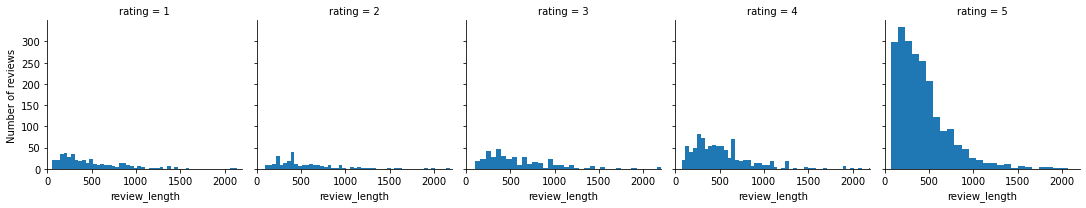

In [39]:
nyc_full['review_length'] = nyc_full['text'].map(len)
# Check how the review lenghts are distributed
ax = sns.FacetGrid(data=nyc_full, col='rating', xlim=(0,2200)).map(plt.hist, 'review_length', bins=50)
ax.axes[0][0].set(ylabel='Number of reviews')

Yep - pretty much the same. They look a little bit different because of the y-axis Number being different, but they follow a very similar pattern. 

## SENTIMENT POLARITY DISTRIBUTION

In [41]:
# make new df with just 'rating' and 'text'

mtl_df = mtl_full[['rating', 'text']]
nyc_df = nyc_full[['rating', 'text']]

In [42]:
# check 
nyc_df.head(1)

,rating,text
0,1,TERRIBLE! TERRIBLE! Worst customer service eve...


In [43]:
# haha wow must have been pretty bad ^ 

# Binarize 
# 0 = ratings 1,2,3 (negative)
# 1 = ratings 4,5 (positive)

# mtl
mtl_df['rating'] = np.where(mtl_df['rating'] >= 4, 1, 0)

# nyc
nyc_df['rating'] = np.where(nyc_df['rating'] >= 4, 1, 0)

<ipython-input-43-dce151c997c4>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mtl_df['rating'] = np.where(mtl_df['rating'] >= 4, 1, 0)
<ipython-input-43-dce151c997c4>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nyc_df['rating'] = np.where(nyc_df['rating'] >= 4, 1, 0)


In [44]:
nyc_df

,rating,text
0,0,TERRIBLE! TERRIBLE! Worst customer service eve...
1,0,Rudest and unprofessional workers ever \nI wou...
2,0,We came to the museum to see the Leonard Cohen...
3,1,Definitely pricey but it's every dessert-lover...
4,1,We like to get egg and cheese bagels here on t...
...,...,...
4212,0,With the closing of my old bagel standby (Bage...
4213,1,Been waiting for Bambu near me to open and it'...
4214,1,This is the cutest family bakery! If you're lo...
4215,1,"The my are open again, got my pastrami fix!! S..."


## REVIEW RATING DISTRIBUTION

#### MTL

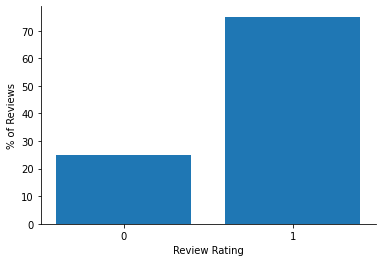

Class imbalance in MTL: [0.25 0.75]


In [45]:
values, counts = np.unique(mtl_df['rating'], return_counts=True)
normalized_counts_mtl = counts/counts.sum()

plt.figure()
plt.bar(["0", "1"], normalized_counts_mtl*100) # plot normalized counts
plt.xlabel('Review Rating')
plt.ylabel('% of Reviews')
sns.despine()
plt.show()

print(f"Class imbalance in MTL: {np.round(normalized_counts_mtl, 2)}")

Right, to be expected, very imbalanced. This may pose problems down the road. Let's check out NYC, which I imagine to be very similar.

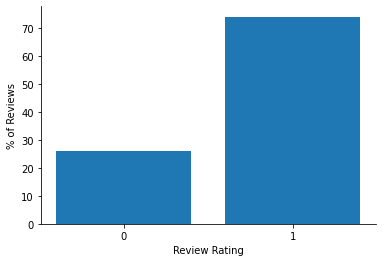

Class imbalance in NYC: [0.26 0.74]


In [46]:
values, counts = np.unique(nyc_df['rating'], return_counts=True)
normalized_counts_nyc = counts/counts.sum()

plt.figure()
plt.bar(["0", "1"], normalized_counts_nyc*100) # plot normalized counts
plt.xlabel('Review Rating')
plt.ylabel('% of Reviews')
sns.despine()
plt.show()

print(f"Class imbalance in NYC: {np.round(normalized_counts_nyc, 2)}")

Slightly less positive but still very imbalanced. 

## SENTIMENT POLARITY 

In [47]:
from sklearn.feature_extraction.text import CountVectorizer

In [49]:
# store simplified data in X and y
# mtl
X_mtl = mtl_df['text']
y_mtl = mtl_df['rating']

# nyc
X_nyc = nyc_df['text']
y_nyc = nyc_df['rating']

In [50]:
normalized_counts_nyc

array([0.25978648, 0.74021352])

In [52]:
mtl_df['rating'].value_counts()

1    2304
0     765
Name: rating, dtype: int64

### - STOPWORDS 
### - TFIDF

Create pos & negative review dfs

In [177]:
neg_reviews = np.where(mtl_df['rating'] == 0)

In [178]:
neg = mtl_df.iloc[neg_reviews]
neg

,index,rating,text,local
3,3,0,So we walked all the way here with high hopes ...,0
7,7,0,Came here for brunch around 11am. Jt wasn't th...,1
11,11,0,Food was okay but took forever to arrive.\n\nS...,1
13,13,0,I've eaten here many times as my daughters liv...,1
25,25,0,"As far Tim Horton's go, this Tim Horton is pre...",1
...,...,...,...,...
3040,3042,0,"Only got drinks, which were fine. Great locati...",0
3041,3043,0,Nothing to write home about. The entrance(s) ...,0
3047,3049,0,Now they have a smoothie masala bar :) im happ...,1
3054,3056,0,"Ok, I get it. This is a busy location. Almost ...",1


In [179]:
pos_reviews = np.where(mtl_df['rating'] == 1)

In [180]:
pos = mtl_df.iloc[pos_reviews]
pos

,index,rating,text,local
0,0,1,I always stop by DFEF for my morning fix every...,0
1,1,1,It's 8am on a Sunday in Montreal. The streets ...,0
2,2,1,This is probably one of my favourite places I'...,0
4,4,1,Came here for brunch with some friends. This s...,1
5,5,1,Quaint coffee shop located in the heart of Mon...,0
...,...,...,...,...
3064,3066,1,"Found out about this bakery on Instagram, and ...",0
3065,3067,1,I've been to this location 3 times and I've ha...,0
3066,3068,1,"Whenever I breeze through Dorval Airport (er, ...",0
3067,3069,1,Came here directly after arriving from the air...,0


In [181]:
neg_reviews = neg
pos_reviews = pos

In [182]:
neg_reviews.drop(columns=['rating', 'local'], inplace=True)
pos_reviews.drop(columns=['rating', 'local'], inplace=True)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [183]:
neg_reviews

,index,text
3,3,So we walked all the way here with high hopes ...
7,7,Came here for brunch around 11am. Jt wasn't th...
11,11,Food was okay but took forever to arrive.\n\nS...
13,13,I've eaten here many times as my daughters liv...
25,25,"As far Tim Horton's go, this Tim Horton is pre..."
...,...,...
3040,3042,"Only got drinks, which were fine. Great locati..."
3041,3043,Nothing to write home about. The entrance(s) ...
3047,3049,Now they have a smoothie masala bar :) im happ...
3054,3056,"Ok, I get it. This is a busy location. Almost ..."


In [185]:
# Convert to array
neg_reviews = neg_reviews[['text']].to_numpy()

In [186]:
# Convert to array
pos_reviews = pos_reviews[['text']].to_numpy()

In [187]:
neg_reviews.shape

(765, 1)

In [188]:
pos_reviews.shape

(2304, 1)

In [193]:
neg_reivews = neg_reviews.reshape([765,])

In [195]:
neg_reviews

array([['So we walked all the way here with high hopes of having some good coffee with extraordinary latte art. Arrived at 630 when they were supposed to close at 8, but were told their coffee machine was cleaned up for the day as it was a holiday and they were closing for 7 instead. Despite that, the staff offered to make us our coffee which we excitedly accepted. That was when the nightmare began.\n\nLittle did we realise that because the coffee machine was already cleaned, the staff had pre-prepared a few shots of coffee contained in the little paper cups circled in my pictures. They then poured that into another cup together with some steam milk and voila, that was our coffee. I have no issue with them closing early on a holiday but ending your coffee service as a cafe 30mins early is just bad business. And to use premade shots (god knows how long ago those shots were prepared) for customers\' coffee is just unbelievable. I have attended artisanal coffee appreciation classes and th

In [197]:
neg_reviews = neg_reviews.flatten()

In [199]:
pos_reviews = pos_reviews.flatten()

In [158]:
from sklearn.feature_extraction import text

In [159]:
stop_words = text.ENGLISH_STOP_WORDS

In [206]:
%%time
from sklearn.feature_extraction.text import TfidfVectorizer

# Create a vectorizer object to generate term document counts
tfidf_pos = TfidfVectorizer(stop_words=stop_words, min_df=10, max_df=0.5, 
                        ngram_range=(1,1), token_pattern='[a-z][a-z]+')

tfidf_neg = TfidfVectorizer(stop_words=stop_words, min_df=10, max_df=0.5, 
                        ngram_range=(1,1), token_pattern='[a-z][a-z]+')

# Get random subset of reviews
np.random.seed(38)
num_reviews = 2000
random_neg = np.random.choice(neg_reviews, size=num_reviews)
random_pos = np.random.choice(pos_reviews, size=num_reviews)

dicty = {'bagels':'bagel', 'burgers':'burger', 'ordered':'order',
         'prices':'price', 'topping':'toppings'}
def replace_words(text, dicty):
    '''Returns text with word substitutions made according
       to the passed `dicty` dictionary'''
    for i,j in dicty.items():
        text = text.replace(i,j)
    return text

random_neg = [replace_words(w, dicty) for w in random_neg]
random_pos = [replace_words(w, dicty) for w in random_pos]

# Get the vectors
neg_vectors = tfidf_neg.fit_transform(random_neg)
pos_vectors = tfidf_pos.fit_transform(random_pos)

CPU times: user 393 ms, sys: 10.7 ms, total: 404 ms
Wall time: 418 ms


In [207]:
# Store TFIDF vectors in a df for later use
neg_df = pd.DataFrame(neg_vectors.todense(), columns=[tfidf_neg.get_feature_names()])
pos_df = pd.DataFrame(pos_vectors.todense(), columns=[tfidf_pos.get_feature_names()])

# get mean for each word
# high mean = important
col_means_neg = {}
for col in neg_df:
    col_means_neg[col] = neg_df[col].mean()

col_means_pos = {}
for col in pos_df:
    col_means_pos[col] = pos_df[col].mean()

In [208]:
no_top_words = 8

print('Top %d words in POSITIVE reviews:' %no_top_words, end='')
print(sorted(col_means_pos, key=col_means_pos.get, reverse=True)[:no_top_words])

print('Top %d words in NEGATIVE reviews:' %no_top_words, end='')
print(sorted(col_means_neg, key=col_means_neg.get, reverse=True)[:no_top_words])

Top 8 words in POSITIVE reviews:[('bagel',), ('place',), ('great',), ('good',), ('food',), ('coffee',), ('service',), ('montreal',)]
Top 8 words in NEGATIVE reviews:[('bagel',), ('food',), ('good',), ('place',), ('coffee',), ('order',), ('service',), ('just',)]


- It appears that the top words for both positive and negative reviews revolve around service
- The only real difference is that the positive review column has 'great' in it. 
- We need to move past using some topic analysis to see which words occur frequently, then analyze which words get grouped together in the same space.

### LSA 

In [209]:
# LSA
from gensim import corpora, models, similarities, matutils

# Convert to gensim corpus
# Transpose
tfidf_pos_corp = matutils.Sparse2Corpus(pos_vectors.transpose())
tfidf_neg_corp = matutils.Sparse2Corpus(neg_vectors.transpose())

# Row indices
id2word_pos = dict((v,k) for k,v in tfidf_pos.vocabulary_.items())
id2word_neg = dict((v,k) for k,v in tfidf_neg.vocabulary_.items())

id2word_pos = corpora.Dictionary.from_corpus(tfidf_pos_corp, id2word=id2word_pos)
id2word_neg = corpora.Dictionary.from_corpus(tfidf_neg_corp, id2word=id2word_neg)


Create the LSA model now

In [210]:
# LSA model
num_topics = 20
lsi_pos = models.LsiModel(tfidf_pos_corp, id2word=id2word_pos, num_topics=num_topics)
lsi_neg = models.LsiModel(tfidf_neg_corp, id2word=id2word_neg, num_topics=num_topics)

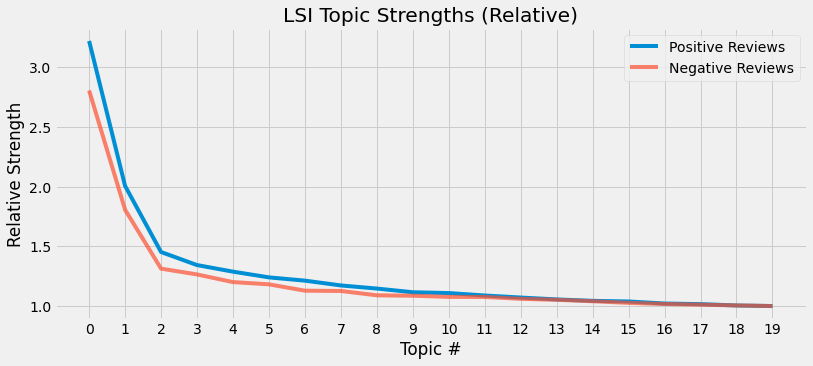

In [211]:
# elbow plot
singular_values_pos = lsi_pos.projection.s.tolist()
singular_values_pos_rel = [sv/singular_values_pos[-1] for sv in singular_values_pos]
singular_values_neg = lsi_neg.projection.s.tolist()
singular_values_neg_rel = [sv/singular_values_neg[-1] for sv in singular_values_neg]

plt.style.use('fivethirtyeight')
plt.figure(figsize=(15,5))
plt.plot(range(len(singular_values_pos)), singular_values_pos_rel, label='Positive Reviews', alpha=1.0)
plt.plot(range(len(singular_values_neg)), singular_values_neg_rel, label='Negative Reviews', alpha=0.7)
plt.xticks(range(len(singular_values_pos)), range(len(singular_values_pos)))
plt.xlabel('Topic #')
plt.ylabel('Relative Strength')
plt.title('LSI Topic Strengths (Relative)')
plt.legend(loc=0, fontsize='medium');

This elbow plot shows that the first two topics are about 3x stronger a differentiator than the rest of the topics. 

Why don't we go ahead with the first 5 topics to continue the analysis.

In [212]:
topics = 5

In [214]:
# check out top 5 positive topics
print('Top %d topics for POSITIVE reviews' %(topics))
print('-'*33)
print(lsi_pos.show_topics()[0:topics])

Top 5 topics for POSITIVE reviews
---------------------------------
[(0, '0.298*"bagel" + 0.194*"place" + 0.184*"great" + 0.178*"good" + 0.162*"food" + 0.146*"coffee" + 0.130*"montreal" + 0.128*"service" + 0.128*"delicious" + 0.126*"really"'), (1, '0.818*"bagel" + 0.153*"sesame" + -0.130*"food" + -0.119*"great" + -0.100*"service" + 0.098*"fairmount" + 0.097*"st" + 0.096*"cream" + -0.095*"brunch" + 0.094*"viateur"'), (2, '0.363*"smoked" + 0.352*"meat" + 0.293*"sandwich" + -0.288*"coffee" + 0.262*"chicken" + -0.192*"great" + 0.153*"fries" + 0.139*"order" + 0.131*"salmon" + -0.111*"nice"'), (3, '-0.304*"brunch" + 0.279*"coffee" + 0.278*"sandwich" + 0.218*"great" + -0.197*"eggs" + -0.186*"breakfast" + 0.155*"meat" + 0.154*"cafe" + -0.142*"menu" + 0.142*"place"'), (4, '0.361*"great" + 0.254*"smoked" + 0.247*"food" + 0.246*"service" + -0.200*"chicken" + 0.185*"meat" + -0.176*"coffee" + -0.154*"chocolate" + 0.129*"salmon" + -0.123*"croissant"')]


In [216]:
# check out top 5 negative topics
print('Top %d topics for NEGATIVE reviews' %(topics))
print('-'*33)
print(lsi_neg.show_topics()[0:topics])

Top 5 topics for NEGATIVE reviews
---------------------------------
[(0, '0.297*"bagel" + 0.184*"food" + 0.176*"good" + 0.168*"place" + 0.153*"order" + 0.146*"coffee" + 0.133*"service" + 0.131*"just" + 0.119*"got" + 0.118*"like"'), (1, '0.812*"bagel" + 0.159*"cheese" + 0.143*"cream" + -0.120*"food" + -0.093*"place" + 0.086*"toasted" + 0.085*"shop" + -0.083*"brunch" + -0.082*"restaurant" + -0.077*"eggs"'), (2, '-0.434*"coffee" + 0.172*"eggs" + -0.155*"latte" + -0.144*"people" + -0.137*"tim" + -0.125*"starbucks" + 0.123*"meat" + -0.117*"cafe" + 0.112*"chicken" + -0.110*"staff"'), (3, '-0.275*"coffee" + 0.169*"minutes" + 0.166*"food" + -0.156*"latte" + -0.151*"cafe" + -0.147*"place" + 0.146*"order" + 0.144*"asked" + -0.140*"breakfast" + 0.134*"restaurant"'), (4, '0.254*"eggs" + 0.243*"breakfast" + -0.226*"chicken" + 0.196*"coffee" + -0.169*"fries" + -0.165*"meat" + -0.162*"tea" + 0.144*"toast" + 0.139*"fruit" + 0.133*"french"')]


It's clearly a little difficult to interpret LSA.

How can I provide insight into what bagel shops people like the most by telling them the most excluded words...?

Let's try NMF - and only return the positive word weights, which seems a bit more intuitive.

### NMF 

In [376]:
%%time
# negative values in LSA topics are not working
# could have better luck with NMF
from sklearn.decomposition import NMF

# change num_topics
num_topics = 6

nmf_pos = NMF(n_components=num_topics)
W_pos = nmf_pos.fit_transform(pos_vectors)
H_pos = nmf_pos.components_

nmf_neg = NMF(n_components=num_topics)
W_neg = nmf_neg.fit_transform(neg_vectors)
H_neg = nmf_neg.components_

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "


CPU times: user 681 ms, sys: 233 ms, total: 914 ms
Wall time: 796 ms


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "


In [377]:
def display_topics(model, feature_names, num_topics, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        if topic_idx < num_topics:
            print("{:11}".format("Topic %d:" %(topic_idx)), end='')
            print(", ".join(['{:04.3f}*'.format(topic[i])+feature_names[i] \
                             for i in topic.argsort()[:-no_top_words-1:-1]]))

no_topics = num_topics
no_top_words = 6

print('Top topics + words for POSITIVE reviews')
print('-'*39)
display_topics(nmf_pos, tfidf_pos.get_feature_names(), no_topics, no_top_words)

print('\nTop topics + words for NEGATIVE reviews')
print('-'*39)
display_topics(nmf_neg, tfidf_neg.get_feature_names(), no_topics, no_top_words)

Top topics + words for POSITIVE reviews
---------------------------------------
Topic 0:   0.937*breakfast, 0.901*brunch, 0.705*eggs, 0.506*menu, 0.463*order, 0.415*benedict
Topic 1:   2.241*bagel, 0.360*sesame, 0.341*cream, 0.328*cheese, 0.269*fresh, 0.254*st
Topic 2:   1.201*smoked, 1.176*meat, 0.556*sandwich, 0.396*montreal, 0.377*poutine, 0.344*salmon
Topic 3:   1.139*coffee, 0.490*place, 0.458*cafe, 0.355*nice, 0.315*little, 0.304*like
Topic 4:   1.264*chicken, 0.525*sauce, 0.458*fried, 0.399*spicy, 0.326*salad, 0.325*order
Topic 5:   1.076*great, 0.893*food, 0.775*service, 0.435*good, 0.390*amazing, 0.355*place

Top topics + words for NEGATIVE reviews
---------------------------------------
Topic 0:   0.662*place, 0.605*good, 0.545*breakfast, 0.468*eggs, 0.430*brunch, 0.371*french
Topic 1:   1.861*bagel, 0.416*cheese, 0.346*cream, 0.165*montreal, 0.159*shop, 0.151*good
Topic 2:   1.275*coffee, 0.332*latte, 0.274*cafe, 0.234*milk, 0.215*ok, 0.215*caf
Topic 3:   0.561*order, 0.431*

Is this more interpretable? 

- First 2 topics for Positive seem to be (1) smoked bagel (salmon probably), (2) coffee
    - looking deeper we see *amazing, service, great, brunch, fresh
- First 2 topics for Negative seem to be the same... bagel and coffee. 
    - But looking deeper we see that things related to service are important too : *took (as in time I guess), *asked, *minutes, *order, *staff, *time

### Review Similarity in NMF space

In [378]:
# look at a random positive review
review_num = np.random.randint(0, high=len(random_pos))
print(review_num)
print(random_pos[review_num])

1433
Good reliable brunch place in NDG.  The exterior is deceptive, it's very nondescript, you'd walk past it a dozen times and never think to go in.  Inside though it's a fairly large space with cute photos of the neighbourhood on the walls, playing up the "orange" in the cafe's name. 

They have a nice broad brunch menu, with lots of smoothies, egg options and the usual pancake and waffles.  I had the veggie omelette which came with toast and a generous helping of home fries which were very good, came with lots of big chunks of onion and bell pepper mixed in.  Portions are big but not overwhelmingly so. Coffee is decent and refills are prompt.  Service is efficient and friendly.

There's usually a lineup on weekends starting around 11, so get there early.  If you are stuck waiting, you can always go for a browse at the used bookstore next door!


In [379]:
# compute cosine similarities of this review wiht the rest
import sklearn.metrics.pairwise as smp

cosines = {}
for ind, review in enumerate(W_pos):
    similarity = smp.cosine_similarity(W_pos[review_num].reshape(1,-1), review.reshape(1,-1))
    cosines[ind] = similarity[0][0]

In [380]:
# get top 3 matching reviews
for n in sorted(cosines, key=cosines.get, reverse=True)[1:4]:
    print('-'*50)
    print('>> Similarity {:.3f}'.format(cosines[n]))
    print(random_pos[n])
print('-'*50)

--------------------------------------------------
>> Similarity 1.000
Very pleasant coffee shop, great for breakfast or light lunch. 
The service was very good; they took a tad longer than usual to serve the cortado we order, so they offered us a free baked good (we picked a chocolatine). The bagel were quite cheap and they were generous on the cream cheese. And it's not just any bagel - it's St-Viateur! 

I hesitated on their bagel sandwiches because I wasn't sure if the portion size would be worth it, but after looking at pictures online I decided I'll try one next time!
--------------------------------------------------
>> Similarity 0.996
Large restaurant with sitting outdoors, indoors first floor or second floor.

Huge menu, could probably eat here 5 days in a row and not get tired of it.

Large portions, delicious food.

Can't go wrong with the recommended section of their menu.

High Rise Pancakes: fresh and fluffy. I like the variety it comes with: over easy egg, syrup, potato

The NMF is working well and making good topics I think, more interpretable anyways. 
Let's try the TFIDF and try topic modeling through LDA.

In [381]:
from sklearn.feature_extraction.text import CountVectorizer

# Create a vectorizer object to generate term document counts
cv_pos = CountVectorizer(stop_words=stop_words, min_df=10, max_df=0.5, 
                        ngram_range=(1,1), token_pattern='[a-z][a-z]+')

cv_neg = CountVectorizer(stop_words=stop_words, min_df=10, max_df=0.5, 
                        ngram_range=(1,1), token_pattern='[a-z][a-z]+')

# Get random subset of reviews
np.random.seed(38)
num_reviews = 15000
cv_random_neg = np.random.choice(neg_reviews, size=num_reviews)
cv_random_pos = np.random.choice(pos_reviews, size=num_reviews)

# replace words from defined dictionary 'dicty'
cv_random_neg = [replace_words(w, dicty) for w in cv_random_neg]
cv_random_pos = [replace_words(w, dicty) for w in cv_random_pos]

# Get the cv vectors
cv_neg_vectors = cv_neg.fit_transform(cv_random_neg).transpose()
cv_pos_vectors = cv_pos.fit_transform(cv_random_pos).transpose()

In [382]:
# Convert sparse matrix of counts to a gensim corpus
corpus_neg = matutils.Sparse2Corpus(cv_neg_vectors)
corpus_pos = matutils.Sparse2Corpus(cv_pos_vectors)

# save a mapping (dict) of row id to word (token) for later use by gensim 
id2word_cv_pos = dict((v, k) for k, v in cv_pos.vocabulary_.items())
id2word_cv_neg = dict((v, k) for k, v in cv_neg.vocabulary_.items())

In [383]:
%%time
# create lda multicore model
lda_pos = models.ldamulticore.LdaMulticore(corpus=corpus_pos, num_topics=5, 
                                           id2word=id2word_cv_pos, passes=10, workers=15)
lda_neg = models.ldamulticore.LdaMulticore(corpus=corpus_neg, num_topics=5, 
                                           id2word=id2word_cv_neg, passes=10, workers=15)

CPU times: user 4min 3s, sys: 17.6 s, total: 4min 21s
Wall time: 6min 21s


In [384]:
print('Top topics + words for POSITIVE reviews')
print('-'*39)
print(lda_pos.print_topics(num_words=7))

print('\nTop topics + words for NEGATIVE reviews')
print('-'*39)
print(lda_neg.print_topics(num_words=7))

Top topics + words for POSITIVE reviews
---------------------------------------
[(0, '0.009*"good" + 0.009*"order" + 0.007*"like" + 0.007*"menu" + 0.007*"coffee" + 0.006*"place" + 0.006*"food"'), (1, '0.034*"bagel" + 0.015*"place" + 0.012*"good" + 0.011*"great" + 0.010*"montreal" + 0.009*"food" + 0.008*"really"'), (2, '0.014*"bagel" + 0.010*"delicious" + 0.010*"cheese" + 0.009*"food" + 0.009*"place" + 0.009*"good" + 0.008*"chicken"'), (3, '0.015*"place" + 0.010*"coffee" + 0.010*"like" + 0.009*"just" + 0.008*"good" + 0.008*"great" + 0.007*"cafe"'), (4, '0.016*"place" + 0.016*"great" + 0.015*"food" + 0.014*"good" + 0.011*"service" + 0.010*"coffee" + 0.009*"breakfast"')]

Top topics + words for NEGATIVE reviews
---------------------------------------
[(0, '0.012*"food" + 0.010*"order" + 0.009*"service" + 0.009*"bagel" + 0.008*"came" + 0.008*"good" + 0.008*"got"'), (1, '0.012*"coffee" + 0.011*"place" + 0.010*"good" + 0.010*"service" + 0.009*"order" + 0.007*"came" + 0.007*"food"'), (2, '0.0

NMF is more interpretable and less blended together. Let's move forward with NMF

In [385]:
# let's double check the positive topics
print('Top topics + words for POSITIVE reviews')
print('-'*39)
display_topics(nmf_pos, tfidf_pos.get_feature_names(), no_topics, no_top_words)

Top topics + words for POSITIVE reviews
---------------------------------------
Topic 0:   0.937*breakfast, 0.901*brunch, 0.705*eggs, 0.506*menu, 0.463*order, 0.415*benedict
Topic 1:   2.241*bagel, 0.360*sesame, 0.341*cream, 0.328*cheese, 0.269*fresh, 0.254*st
Topic 2:   1.201*smoked, 1.176*meat, 0.556*sandwich, 0.396*montreal, 0.377*poutine, 0.344*salmon
Topic 3:   1.139*coffee, 0.490*place, 0.458*cafe, 0.355*nice, 0.315*little, 0.304*like
Topic 4:   1.264*chicken, 0.525*sauce, 0.458*fried, 0.399*spicy, 0.326*salad, 0.325*order
Topic 5:   1.076*great, 0.893*food, 0.775*service, 0.435*good, 0.390*amazing, 0.355*place


In [386]:
# let's look at a random positive review and see the topic distribution of the review
review_num = np.random.randint(0, high=len(random_pos))
print('Positive Review #%d' %review_num)
print('-'*25)
print(random_pos[review_num])
print('-'*25)
topic_dict = {}
for ind, w in enumerate(W_pos[review_num]):
    topic_dict[ind] = w
for k in sorted(topic_dict, key=topic_dict.get, reverse=True):
     print('Topic {}: {:.4f}'.format(k, topic_dict[k]))

Positive Review #431
-------------------------
No reservations needed for a group of four on a Saturday morning. Packed restaurant with lots of enticing dishes to choose from as you're waiting to place your order.

Again, the menu has all sorts of options, but couldn't say no to the Breakfast Poutine ($12). A layering of home fries, curds, Hollondaise, gravy, bacon, and a sunny-side up egg. Despite everything involved in the dish, the portion size was moderate enough to not make you too full. Fries are crisp and the egg/bacon is always a good combination.

Service can take a little bit considering the crowd, but not egregiously slow. Would come back again to try a crepe.
-------------------------
Topic 4: 0.2256
Topic 0: 0.0185
Topic 3: 0.0047
Topic 5: 0.0038
Topic 1: 0.0000
Topic 2: 0.0000


In [387]:
print('Top topics + words for NEGATIVE reviews')
print('-'*39)
display_topics(nmf_neg, tfidf_neg.get_feature_names(), no_topics, no_top_words)

Top topics + words for NEGATIVE reviews
---------------------------------------
Topic 0:   0.662*place, 0.605*good, 0.545*breakfast, 0.468*eggs, 0.430*brunch, 0.371*french
Topic 1:   1.861*bagel, 0.416*cheese, 0.346*cream, 0.165*montreal, 0.159*shop, 0.151*good
Topic 2:   1.275*coffee, 0.332*latte, 0.274*cafe, 0.234*milk, 0.215*ok, 0.215*caf
Topic 3:   0.561*order, 0.431*food, 0.318*minutes, 0.316*asked, 0.285*took, 0.265*came
Topic 4:   0.918*chicken, 0.388*ok, 0.286*fries, 0.264*salad, 0.254*fried, 0.222*just
Topic 5:   0.571*tim, 0.428*donuts, 0.349*hortons, 0.324*people, 0.315*line, 0.309*airport


In [390]:
# now let's look at a random negative review and see the topic distribution of the review
review_num = np.random.randint(0, high=len(random_neg))
print('Negative Review #%d' %review_num)
print('-'*25)
print(random_neg[review_num])
print('-'*25)
topic_dict = {}
for ind, w in enumerate(W_neg[review_num]):
    topic_dict[ind] = w
for k in sorted(topic_dict, key=topic_dict.get, reverse=True):
     print('Topic {}: {:.4f}'.format(k, topic_dict[k]))

Negative Review #404
-------------------------
I really hesitated between a three and four star for this place. The first thing I must declare is that Le Trou is no contender for conventional Montreal bagel. For me, the real test is when you go to toast the bagel: the crispy/chewy ratio, the sweetness and certainly the spreadability (for other items on top, of course). Le Trou doesn't quite deliver on the first two criteria but it does support toppingss very well. Thus far we've tried all of the flavours offered, with the exception of the cinnamon-raisin. The only flavour that really stands out to me is their signature bagel: the Griffintown (beer and cheese flavour). The problem with my affinity for this bagel is that it's the only one that isn't regularly priced: half a dozen for any of the other flavours hovers around the $5-6 range while the Griffintown will set you back $15 (!) for six. I think this is more than a bit much, frankly.

What I really value about le Trou is that the m

### Topic Modelling All Reviews

At this point, we can see that our topics are fairly interpretable and match along with the reviews they're trying to categorize. It would be much better if we had more review data, as there is still a good deal of overlap... But let's proceed with topic modeling all reviews and bagel shops using NMF.

In [391]:
print('Postive Reviews:  {:,}'.format(len(pos_reviews)))
print('Negative Reviews:  {:,}'.format(len(neg_reviews)))

Postive Reviews:  2,304
Negative Reviews:  765


As we can see - still a lot of imbalance. Would be good to create a ML pipeline for easy ingestion of new data. Soemthing to look into if there is time.

In [392]:
%%time
# Create a vectorizer object to generate term document counts
tfidf_pos = TfidfVectorizer(stop_words=stop_words, min_df=10, max_df=0.5, 
                        ngram_range=(1,1), token_pattern='[a-z][a-z]+')

tfidf_neg = TfidfVectorizer(stop_words=stop_words, min_df=10, max_df=0.5, 
                        ngram_range=(1,1), token_pattern='[a-z][a-z]+')

# replace words 
pos_reviews = [replace_words(w, dicty) for w in pos_reviews]
neg_reviews = [replace_words(w, dicty) for w in neg_reviews]

# Get the vectors
neg_vectors = tfidf_neg.fit_transform(neg_reviews)
pos_vectors = tfidf_pos.fit_transform(pos_reviews)

CPU times: user 311 ms, sys: 50.5 ms, total: 361 ms
Wall time: 460 ms


In [393]:
%%time
# NMF for all reviews
from sklearn.decomposition import NMF

# change num_topics
num_topics = 6

nmf_pos = NMF(n_components=num_topics)
W_pos = nmf_pos.fit_transform(pos_vectors)
H_pos = nmf_pos.components_

nmf_neg = NMF(n_components=num_topics)
W_neg = nmf_neg.fit_transform(neg_vectors)
H_neg = nmf_neg.components_

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "


CPU times: user 593 ms, sys: 99.3 ms, total: 692 ms
Wall time: 592 ms


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "


In [394]:
no_topics = num_topics
no_top_words = 6

print('Topics for POSITIVE reviews')
print('-'*39)
display_topics(nmf_pos, tfidf_pos.get_feature_names(), no_topics, no_top_words)

print('\nTopics for NEGATIVE reviews')
print('-'*39)
display_topics(nmf_neg, tfidf_neg.get_feature_names(), no_topics, no_top_words)

Topics for POSITIVE reviews
---------------------------------------
Topic 0:   0.937*breakfast, 0.901*brunch, 0.705*eggs, 0.506*menu, 0.463*order, 0.415*benedict
Topic 1:   2.241*bagel, 0.360*sesame, 0.342*cream, 0.328*cheese, 0.269*fresh, 0.253*st
Topic 2:   1.200*smoked, 1.176*meat, 0.556*sandwich, 0.396*montreal, 0.377*poutine, 0.344*salmon
Topic 3:   1.138*coffee, 0.489*place, 0.458*cafe, 0.354*nice, 0.315*little, 0.304*like
Topic 4:   1.264*chicken, 0.525*sauce, 0.458*fried, 0.399*spicy, 0.326*salad, 0.325*order
Topic 5:   1.075*great, 0.893*food, 0.775*service, 0.435*good, 0.390*amazing, 0.355*place

Topics for NEGATIVE reviews
---------------------------------------
Topic 0:   0.662*place, 0.605*good, 0.545*breakfast, 0.468*eggs, 0.430*brunch, 0.371*french
Topic 1:   1.861*bagel, 0.416*cheese, 0.346*cream, 0.165*montreal, 0.159*shop, 0.151*good
Topic 2:   1.275*coffee, 0.332*latte, 0.274*cafe, 0.234*milk, 0.215*ok, 0.215*caf
Topic 3:   0.562*order, 0.432*food, 0.319*minutes, 0.3

Let's create 2 topic dictionaries that summarize the meanings of each topic:

In [1]:
# create topic dictionaries
pos_topics = {0:'breakfast/brunch', 1:'bagel/ingredients', 2:'montreal', 
              3:'cafe/coffee/atmosphere', 4:'other_food', 5:'great_service'}

neg_topics = {0:'breakfast/brunch', 1:'bagel/ingredients', 2:'coffee/cafe', 
              3:'bad_service', 4:'other_food', 5:'atmosphere'}

In [348]:
pos_df = np.where(mtl_full['rating'] >=4)

In [349]:
df_pos = mtl_df.iloc[pos_df]


In [358]:
df_neg = mtl_df.iloc[neg_df]

In [350]:
df_pos.drop(columns='index', inplace=True)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [360]:
df_neg.drop(columns='index', inplace=True)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [352]:
business_names = mtl_full['res_name']

In [353]:
df_pos = df_pos.join(business_names)

In [354]:
df_pos

,rating,text,local,res_name
0,1,I always stop by DFEF for my morning fix every...,0,De Farine et d’Eau Fraîche
1,1,It's 8am on a Sunday in Montreal. The streets ...,0,Second Cup
2,1,This is probably one of my favourite places I'...,0,Cora
4,1,Came here for brunch with some friends. This s...,1,L’Oeufrier
5,1,Quaint coffee shop located in the heart of Mon...,0,Café Nocturne
...,...,...,...,...
3064,1,"Found out about this bakery on Instagram, and ...",0,Café Osmo
3065,1,I've been to this location 3 times and I've ha...,0,Boulangerie Cheskie
3066,1,"Whenever I breeze through Dorval Airport (er, ...",0,Boulangerie Cheskie
3067,1,Came here directly after arriving from the air...,0,L’Oeufrier


In [363]:
df_neg = df_neg.join(business_names)

In [364]:
df_neg

,rating,text,local,res_name
3,0,So we walked all the way here with high hopes ...,0,Café Castel
7,0,Came here for brunch around 11am. Jt wasn't th...,1,Eggspectation
11,0,Food was okay but took forever to arrive.\n\nS...,1,La Boîte Gourmande
13,0,I've eaten here many times as my daughters liv...,1,Notre-Boeuf-de-Grâce
25,0,"As far Tim Horton's go, this Tim Horton is pre...",1,Tim Hortons
...,...,...,...,...
3040,0,"Only got drinks, which were fine. Great locati...",0,L’Inconnu
3041,0,Nothing to write home about. The entrance(s) ...,0,Pastaga
3047,0,Now they have a smoothie masala bar :) im happ...,1,Café Vasco da Gama
3054,0,"Ok, I get it. This is a busy location. Almost ...",1,Tommy


In [343]:
review_lengths = mtl_full['review_length']
review_lengths

0        301
1        826
2        327
3       1252
4        673
        ... 
3066    1135
3067     640
3068    2523
3069     605
3070     463
Name: review_length, Length: 3069, dtype: int64

In [366]:
df_pos = df_pos.join(review_lengths)
df_neg = df_neg.join(review_lengths)

In [368]:
df_pos

,rating,text,local,res_name,review_length
0,1,I always stop by DFEF for my morning fix every...,0,De Farine et d’Eau Fraîche,301.0
1,1,It's 8am on a Sunday in Montreal. The streets ...,0,Second Cup,826.0
2,1,This is probably one of my favourite places I'...,0,Cora,327.0
4,1,Came here for brunch with some friends. This s...,1,L’Oeufrier,673.0
5,1,Quaint coffee shop located in the heart of Mon...,0,Café Nocturne,172.0
...,...,...,...,...,...
3064,1,"Found out about this bakery on Instagram, and ...",0,Café Osmo,909.0
3065,1,I've been to this location 3 times and I've ha...,0,Boulangerie Cheskie,277.0
3066,1,"Whenever I breeze through Dorval Airport (er, ...",0,Boulangerie Cheskie,1135.0
3067,1,Came here directly after arriving from the air...,0,L’Oeufrier,640.0


In [369]:
print('Topic weights : ', W_pos[0])
print('Sum of weights: ', W_pos[0].sum())

Topic weights :  [0.00406723 0.00623226 0.00753805 0.06767664 0.02465449 0.01754192]
Sum of weights:  0.12771059405829374


It isn't interpratable that a review is 0.004 for a topic and all the topics sum up to 0.1277. Let's normalize the weights to add up to 1.

In [325]:
from sklearn.preprocessing import normalize
print('Normalized Topic weights : ', normalize(W_pos[0].reshape(1,-1), norm='l1'))
print('Sum of normalized weights: ', normalize(W_pos[0].reshape(1,-1), norm='l1').sum())

Normalized Topic weights :  [[0.03184728 0.04879987 0.05902444 0.52992189 0.19304969 0.13735683]]
Sum of normalized weights:  1.0


In [400]:
df_pos_test = pd.concat([df_pos, pd.DataFrame(normalize(W_pos, norm='l1'))], axis=1)
df_neg_test = pd.concat([df_neg, pd.DataFrame(normalize(W_neg, norm='l1'))], axis=1)

In [402]:
df_pos_test.dropna(inplace=True)

In [422]:
df_neg_test

,rating,text,local,res_name,review_length,0,1,2,3,4,5
3,0.0,So we walked all the way here with high hopes ...,0.0,Café Castel,1252.0,0.119300,0.000000,0.012411,0.582130,0.000000,0.286159
7,0.0,Came here for brunch around 11am. Jt wasn't th...,1.0,Eggspectation,1800.0,0.212107,0.037855,0.000000,0.049340,0.560426,0.140272
11,0.0,Food was okay but took forever to arrive.\n\nS...,1.0,La Boîte Gourmande,264.0,0.321684,0.062038,0.169031,0.289816,0.000000,0.157430
13,0.0,I've eaten here many times as my daughters liv...,1.0,Notre-Boeuf-de-Grâce,1405.0,0.126094,0.253980,0.416436,0.000000,0.203489,0.000000
25,0.0,"As far Tim Horton's go, this Tim Horton is pre...",1.0,Tim Hortons,239.0,0.069786,0.000000,0.042510,0.064821,0.298508,0.524374
...,...,...,...,...,...,...,...,...,...,...,...
739,0.0,The menu is incomplete with no descriptions or...,0.0,Dame Nature,303.0,0.414005,0.000000,0.000000,0.585995,0.000000,0.000000
744,0.0,Don't come here if you're looking for an authe...,0.0,L’Anecdote,512.0,0.264012,0.055029,0.002964,0.085933,0.226972,0.365090
753,0.0,"It should be called Tommy Bagel sans ""s."" Only...",0.0,Le Vieux St-Laurent,322.0,0.494478,0.054177,0.009482,0.364335,0.000000,0.077528
755,0.0,"Tim Hortons is Tim Hortons, right? Most every...",1.0,Café 92,608.0,0.162640,0.000000,0.705011,0.025422,0.000000,0.106927


In [423]:
df_pos_test

,rating,text,local,res_name,review_length,0,1,2,3,4,5
0,1.0,I always stop by DFEF for my morning fix every...,0.0,De Farine et d’Eau Fraîche,301.0,0.031614,0.048789,0.058897,0.530232,0.192573,0.137894
1,1.0,It's 8am on a Sunday in Montreal. The streets ...,0.0,Second Cup,826.0,0.382792,0.043092,0.246588,0.318101,0.009427,0.000000
2,1.0,This is probably one of my favourite places I'...,0.0,Cora,327.0,0.812864,0.000000,0.123384,0.063752,0.000000,0.000000
4,1.0,Came here for brunch with some friends. This s...,1.0,L’Oeufrier,673.0,0.000000,0.000000,0.077290,0.922710,0.000000,0.000000
5,1.0,Quaint coffee shop located in the heart of Mon...,0.0,Café Nocturne,172.0,0.031614,0.048789,0.058897,0.530232,0.192573,0.137894
...,...,...,...,...,...,...,...,...,...,...,...
2298,1.0,"Very pleasant coffee shop, great for breakfast...",1.0,Bagel St-Lo,864.0,0.085079,0.000000,0.042462,0.344737,0.000000,0.527723
2299,1.0,I ordered wrong - veggie melt which was not th...,0.0,Universel,922.0,0.196919,0.075732,0.005755,0.386502,0.130608,0.204484
2300,1.0,I have been wanting to try out James Le Restau...,1.0,Hinnawi Bros Bagel & Café,512.0,0.324296,0.000000,0.000000,0.100125,0.000000,0.575579
2301,1.0,Timmy's is an absolute must when you have a lo...,0.0,Beauty’s Luncheonette,261.0,0.131460,0.137587,0.060530,0.285817,0.210466,0.174140


In [411]:
# group by res_name and apply mean/count functions to columns
df_pos_bsns = df_pos_test.groupby('res_name').agg({'rating':'mean', 'text':'count',
                                                 'review_length':'mean',0:'mean', 
                                                 1:'mean', 2:'mean', 3:'mean',
                                                 4:'mean', 5:'mean'}).reset_index()
df_neg_bsns = df_neg_test.groupby('res_name').agg({'rating':'mean', 'text':'count',
                                                 'review_length':'mean',0:'mean', 
                                                 1:'mean', 2:'mean', 3:'mean',
                                                 4:'mean', 5:'mean'}).reset_index()

In [412]:
df_pos_bsns

,res_name,rating,text,review_length,0,1,2,3,4,5
0,ADONIS,1.0,10,396.100000,0.108188,0.111144,0.035465,0.399603,0.077066,0.268533
1,Allô! Mon Coco,1.0,10,570.100000,0.147237,0.191381,0.087772,0.197435,0.023410,0.352766
2,Archibald Microbrasserie,1.0,10,931.800000,0.117889,0.322585,0.134325,0.183210,0.009094,0.232897
3,Arthurs,1.0,13,1191.846154,0.347320,0.081150,0.160668,0.093604,0.062916,0.254340
4,B & M Restaurant,1.0,18,555.666667,0.192207,0.186845,0.031103,0.264592,0.056529,0.268723
...,...,...,...,...,...,...,...,...,...,...
164,Vieux-Port Steakhouse,1.0,11,984.454545,0.164157,0.101582,0.209791,0.128225,0.148271,0.247974
165,Ville Emard Bagels,1.0,5,228.400000,0.089103,0.000000,0.029425,0.475012,0.068654,0.337806
166,Wienstein & Gavino’s,1.0,11,754.636364,0.124667,0.212895,0.171537,0.317859,0.054099,0.118944
167,Wilensky,1.0,11,582.181818,0.190803,0.184888,0.095451,0.298315,0.047365,0.183178


In [413]:
df_neg_bsns

,res_name,rating,text,review_length,0,1,2,3,4,5
0,Allô! Mon Coco,0.0,2,290.0,0.349456,0.005646,0.345953,0.265259,0.022896,0.010790
1,Archibald Microbrasserie,0.0,2,420.0,0.386652,0.257710,0.000000,0.165208,0.176149,0.014280
2,Arthurs,0.0,1,597.0,0.143685,0.036869,0.318724,0.408705,0.022606,0.069412
3,B & M Restaurant,0.0,3,1129.0,0.064038,0.194958,0.187018,0.509344,0.000480,0.044162
4,Bagel St-Lo,0.0,1,902.0,0.124737,0.494909,0.000000,0.000000,0.007655,0.372699
...,...,...,...,...,...,...,...,...,...,...
102,Universel,0.0,2,438.5,0.277760,0.315228,0.055384,0.000000,0.077162,0.274466
103,Vieux-Port Steakhouse,0.0,2,1389.5,0.281609,0.033714,0.088001,0.098468,0.044983,0.453225
104,Ville Emard Bagels,0.0,1,334.0,0.092907,0.000000,0.000000,0.907093,0.000000,0.000000
105,Wienstein & Gavino’s,0.0,1,1051.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [421]:
%%time
# Write the data to CSV files and use info for visualizations in Flourish
df_pos_bsns.to_csv('data/pos_bsns.csv')
df_neg_bsns.to_csv('data/neg_bsns.csv')

CPU times: user 9.88 ms, sys: 5.76 ms, total: 15.6 ms
Wall time: 41.7 ms


## SAME PROCESS FOR NY

- See other notebook

## CUSTOMER EXPLORATION 

### MTL

In [58]:
# create location dataframes to be exported as CSVs for mapping
mtl_locs = mtl_full[['cus_location', 'cus_name']]

mtl_locs.head()

,cus_location,cus_name
0,"Astoria, Queens, NY",Jedsada Y.
1,"Boston, MA",Peter G.
2,"Toronto, Canada",Kathleen H.
3,"Queens, Queens, NY",Desmond T.
4,"Montreal, Canada",Leo L.


### NYC

In [59]:
nyc_locs = nyc_full[['cus_location', 'cus_name']]

nyc_locs.head()

,cus_location,cus_name
0,"Manhattan, NY",Brian C.
1,"Bronx, New York, NY",Lenis M.
2,"Pompano Beach, FL",Julie F.
3,"New York, NY",Ellen J.
4,"New York, NY",Adam F.


How many customers are from the city and who is visiting? (local / tourist)

In [60]:
mtl_locs['tourist'] = np.where(mtl_locs['cus_location'].str.contains('Montreal'), 1, 0)
print(mtl_locs)

                  cus_location     cus_name  tourist
0          Astoria, Queens, NY   Jedsada Y.        0
1                   Boston, MA     Peter G.        0
2              Toronto, Canada  Kathleen H.        0
3           Queens, Queens, NY   Desmond T.        0
4             Montreal, Canada       Leo L.        1
...                        ...          ...      ...
3066  Vaudreuil-Dorion, Canada    Hilary K.        0
3067               Raleigh, NC    Leanna K.        0
3068         Vancouver, Canada     Nancy H.        0
3069             Manhattan, NY  Rosemary V.        0
3070           Toronto, Canada     Grace L.        0

[3069 rows x 3 columns]


<ipython-input-60-dde93b4f8f44>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mtl_locs['tourist'] = np.where(mtl_locs['cus_location'].str.contains('Montreal'), 1, 0)


In [63]:
# Rename columns
mtl_locs.rename(columns={'tourist': 'local'}, inplace=True)
mtl_locs.head()

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas/core/frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


,cus_location,cus_name,local
0,"Astoria, Queens, NY",Jedsada Y.,0
1,"Boston, MA",Peter G.,0
2,"Toronto, Canada",Kathleen H.,0
3,"Queens, Queens, NY",Desmond T.,0
4,"Montreal, Canada",Leo L.,1


In [64]:
mtl_locs['local'].value_counts()

0    2000
1    1069
Name: local, dtype: int64

Interesting - we have 1,069 locals and 2,000 who don't live in Montreal.

Let's check for New York

In [65]:
nyc_locs['local'] = np.where(nyc_locs['cus_location'].str.contains('NY'), 1, 0)
print(nyc_locs)

             cus_location     cus_name  local
0           Manhattan, NY     Brian C.      1
1     Bronx, New York, NY     Lenis M.      1
2       Pompano Beach, FL     Julie F.      0
3            New York, NY     Ellen J.      1
4            New York, NY      Adam F.      1
...                   ...          ...    ...
4212         New York, NY      Phil H.      1
4213         New York, NY       Dom G.      1
4214         New York, NY   Lindsay K.      1
4215         New York, NY  Lawrence L.      1
4216         New York, NY    Monica T.      1

[4215 rows x 3 columns]


<ipython-input-65-043bcc96812f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nyc_locs['local'] = np.where(nyc_locs['cus_location'].str.contains('NY'), 1, 0)


In [66]:
nyc_locs['local'].value_counts()

1    3130
0    1085
Name: local, dtype: int64

Alright so we've got a lot more 'locals' for NY... 

Interesting. I wonder why that is?

Let's look at the distribution of negative to positive reviews for locals and non-locals.

In [73]:
nyc_df.reset_index(inplace=True)

In [76]:
mtl_df.reset_index(inplace=True)

In [78]:
mtl_locs.reset_index(inplace=True)

In [87]:
nyc_locs.reset_index(inplace=True)

In [85]:
# Merge local to rating df

mtl_df = pd.merge(mtl_df, mtl_locs[['index','local']], on='index', how='left')

In [88]:
mtl_df.head(1)

,index,rating,text,local
0,0,1,I always stop by DFEF for my morning fix every...,0


In [89]:
# Merge local to rating df

nyc_df = pd.merge(nyc_df, nyc_locs[['index','local']], on='index', how='left')

nyc_df.head(1)

,index,rating,text,local
0,0,0,TERRIBLE! TERRIBLE! Worst customer service eve...,1


In [93]:
mtl_full.head()

,res_name,cus_name,cus_location,text,rating,date,review_length
0,De Farine et d’Eau Fraîche,Jedsada Y.,"Astoria, Queens, NY",I always stop by DFEF for my morning fix every...,5,2017-01-03,301
1,Second Cup,Peter G.,"Boston, MA",It's 8am on a Sunday in Montreal. The streets ...,4,2009-06-24,826
2,Cora,Kathleen H.,"Toronto, Canada",This is probably one of my favourite places I'...,4,2019-03-18,327
3,Café Castel,Desmond T.,"Queens, Queens, NY",So we walked all the way here with high hopes ...,1,2018-07-02,1252
4,L’Oeufrier,Leo L.,"Montreal, Canada",Came here for brunch with some friends. This s...,4,2018-12-28,673


In [91]:
import plotly.express as px

## TOPIC MODELLING (first attempt)


In [97]:
from sklearn.feature_extraction.text import CountVectorizer

In [99]:
# store simplified data in X and y
# mtl
X_mtl = mtl_df['text']
y_mtl = mtl_df['rating']

# nyc
X_nyc = nyc_df['text']
y_nyc = nyc_df['rating']

In [101]:
# 1. Instantiate 
bagofwords = CountVectorizer(stop_words="english")

# 2. Fit 
bagofwords.fit(X_mtl)

# 3. Transform
transformed_data = bagofwords.transform(X_mtl)
transformed_data

<3069x9508 sparse matrix of type '<class 'numpy.int64'>'
	with 139848 stored elements in Compressed Sparse Row format>

In [102]:
# converting the sparse matrix into a numpy array
transformed_data.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [103]:
# We can extract the information and put it in a data frame to make it easier to see what has occured
mtl_df2 = pd.DataFrame(columns=bagofwords.get_feature_names(), data=transformed_data.toarray())
display(mtl_df2)

,00,00am,00pm,01,06,10,100,1000,100x,1030,...,zone,zoodles,zucchini,ça,émard,érable,établissement,île,œufs,œuvre
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3064,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3065,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3066,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3067,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [104]:
# splitting our data into train and test sets
from sklearn.model_selection import train_test_split

X_train_mtl, X_test_mtl, y_train_mtl, y_test_mtl = train_test_split(X_mtl, y_mtl, test_size=0.33, random_state=42)

In [105]:
# 1. Instantiate
bagofwords = CountVectorizer()

# 2. Fit
bagofwords.fit(X_train_mtl)

# 3. Transform
X_train_transformed_mtl = bagofwords.transform(X_train_mtl)
X_train_transformed_mtl

<2056x8986 sparse matrix of type '<class 'numpy.int64'>'
	with 152651 stored elements in Compressed Sparse Row format>

In [106]:
X_test_transformed_mtl = bagofwords.transform(X_test_mtl)
X_test_transformed_mtl

<1013x8986 sparse matrix of type '<class 'numpy.int64'>'
	with 76237 stored elements in Compressed Sparse Row format>

In [108]:
words = bagofwords.get_feature_names()
some_indices = range(1, 8986, round(8986/10)) # just pick some indices

samples = [words[i] for i in some_indices]
print(samples)

['00am', 'bkfst', 'conclusion', 'element', 'greasy', 'lassie', 'nuanced', 'puts', 'size', 'timely']


In [109]:
counts = np.array(X_train_transformed_mtl[:, some_indices].sum(axis = 0))

display(pd.DataFrame({"total_corpus_count": counts[0]}, index=samples).T)

,00am,bkfst,conclusion,element,greasy,lassie,nuanced,puts,size,timely
total_corpus_count,2,2,2,5,24,2,2,7,66,8


In [110]:
bagofwords = CountVectorizer(stop_words="english")
bagofwords.fit(X_train_mtl)

X_train_transformed_mtl = bagofwords.transform(X_train_mtl) 
X_test_transformed_mtl = bagofwords.transform(X_test_mtl) 

X_train_transformed_mtl.shape

(2056, 8704)

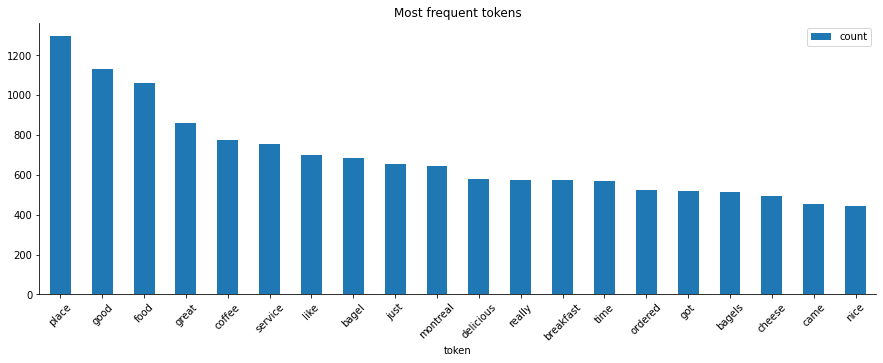

In [113]:
words = bagofwords.get_feature_names()
word_counts = X_train_transformed_mtl.toarray().sum(axis=0)

plot_most_frequent(words, word_counts)

## TOPIC MODELLING cont..

**Topic modeling or topic clustering** is another example applied to text - think of how Google News clusters articles into sport, business, international, politics, etc. A common method is to use **Latent Dirchlet Allocation** (LDA, not to be confused with Linear Discriminant Analysis, which is also abbreviated as LDA), which is a type of unsupervised learning.
We could also use **Non-negative Matrix Factorization** (NMF). 


In [115]:
from sklearn.decomposition import LatentDirichletAllocation

# fit the LDA topic model
lda = LatentDirichletAllocation(n_components=10, 
                                max_iter=5,
                                random_state=0
                               )
lda.fit(X_train_transformed_mtl)

LatentDirichletAllocation(max_iter=5, random_state=0)

In [116]:
# for each topic, print the the top 10 most representative words
words = tfidf.get_feature_names()

for i, topic in enumerate(lda.components_):
    topic_words = " ".join([words[j] for j in topic.argsort()[: -11: -1]])
    print(f"Topic #{i} words: {topic_words}")

Topic #0 words: caraway native even sister indie film flavourings fingerling praise sometimes
Topic #1 words: even native fingerling flavourings matters breeze chaos protein matza sister
Topic #2 words: chaos hesitate native even flavourings aspires montréal protein blackberries sister
Topic #3 words: kidney refilled flavourings film native even potions cousin pestered indie
Topic #4 words: native indie flavourings cantaloup film lentil seasons cousin paninis hesitate
Topic #5 words: native even protein film sister flavourings cousin steam cantaloup matza
Topic #6 words: aspires assemble native cantaloup film lentil cousin complements flavourings potions
Topic #7 words: film chaos native even boiled protein flavourings paninis cousin lovelier
Topic #8 words: even film flavourings native protein pestered fingerling expire rightly boiled
Topic #9 words: native film blackberries paninis indie hesitate matza chaos lentil even


In [117]:
# 1. Instantiate 
bagofwords = CountVectorizer(stop_words="english")

# 2. Fit 
bagofwords.fit(X_nyc)

# 3. Transform
transformed_data = bagofwords.transform(X_nyc)
transformed_data

<4215x8247 sparse matrix of type '<class 'numpy.int64'>'
	with 150469 stored elements in Compressed Sparse Row format>

In [118]:
# converting the sparse matrix into a numpy array
transformed_data.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [119]:
# We can extract the information and put it in a data frame to make it easier to see what has occured
nyc_df2 = pd.DataFrame(columns=bagofwords.get_feature_names(), data=transformed_data.toarray())
display(nyc_df2)

,00,000,00pm,02,03,05,07,08,10,100,...,zaro,zataar,zecchini,zeppoles,zero,zip,zoom,zucchini,zucker,zuckers
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4210,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4211,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4212,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4213,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [120]:
# splitting our data into train and test sets
from sklearn.model_selection import train_test_split

X_train_nyc, X_test_nyc, y_train_nyc, y_test_nyc = train_test_split(X_nyc, y_nyc, test_size=0.33, random_state=42)

In [122]:
# 1. Instantiate
bagofwords = CountVectorizer()

# 2. Fit
bagofwords.fit(X_train_nyc)

# 3. Transform
X_train_transformed_nyc = bagofwords.transform(X_train_nyc)
X_train_transformed_nyc

<2824x7989 sparse matrix of type '<class 'numpy.int64'>'
	with 170720 stored elements in Compressed Sparse Row format>

In [124]:
words = bagofwords.get_feature_names()
some_indices = range(1, 8247, round(8247/10)) # just pick some indices

samples = [words[i] for i in some_indices]
print(samples)

['000', 'bets', 'confused', 'employee', 'half', 'limon', 'outlet', 'refried', 'sound', 'unbelievable']


In [125]:
counts = np.array(X_train_transformed_nyc[:, some_indices].sum(axis = 0))

display(pd.DataFrame({"total_corpus_count": counts[0]}, index=samples).T)

,000,bets,confused,employee,half,limon,outlet,refried,sound,unbelievable
total_corpus_count,2,2,13,19,99,1,5,1,3,4


In [126]:
bagofwords = CountVectorizer(stop_words="english")
bagofwords.fit(X_train_nyc)

X_train_transformed_nyc = bagofwords.transform(X_train_nyc) 
X_test_transformed_nyc = bagofwords.transform(X_test_nyc) 

X_train_transformed_nyc.shape

(2824, 7709)

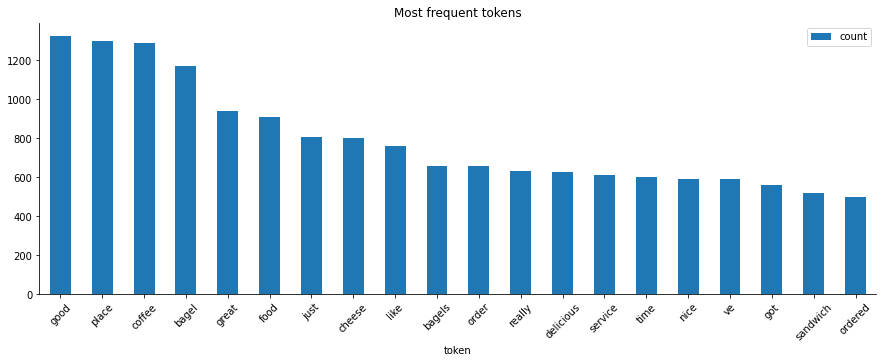

In [127]:
words = bagofwords.get_feature_names()
word_counts = X_train_transformed_nyc.toarray().sum(axis=0)

plot_most_frequent(words, word_counts)

In [128]:
from sklearn.decomposition import LatentDirichletAllocation

# fit the LDA topic model
lda = LatentDirichletAllocation(n_components=10, 
                                max_iter=5,
                                random_state=0
                               )
lda.fit(X_train_transformed_nyc)

LatentDirichletAllocation(max_iter=5, random_state=0)

In [129]:
# for each topic, print the the top 10 most representative words
words = tfidf.get_feature_names()

for i, topic in enumerate(lda.components_):
    topic_words = " ".join([words[j] for j in topic.argsort()[: -11: -1]])
    print(f"Topic #{i} words: {topic_words}")

Topic #0 words: carefully esposito complimentary enjoyably literary mingle cherries cafe juniper intended
Topic #1 words: drama juniper enjoyably literary gateway nutella esposito grinding junky as
Topic #2 words: enjoyably as literary ordered carefully pit roaster grinding ramps gateway
Topic #3 words: as ashamed carefully enjoyably literary esposito bus ck ramps ordered
Topic #4 words: as bus drama ck enjoyably grinding artists buttery customers junky
Topic #5 words: literary enjoyably mingle gateway grinding baguette handful relic intended esposito
Topic #6 words: nut carefully complimentary drama enjoyably literary ramps beyonce esposito complexity
Topic #7 words: literary carefully enjoyably pit gateway 1000 grinding handful roaster drama
Topic #8 words: carefully enjoyably bored esposito literary handful gossiping nut alexandra dumb
Topic #9 words: esposito literary bus carefully intended enjoyably gateway as protective ck


## WORD2VEC (aborted Word2Vec mission, will revisit)

In [130]:
from gensim.models import Word2Vec
import time

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [132]:
# Create sample to test this on because I believe it takes a long time and want to make sure it's set up right
text = mtl_df['text']

In [133]:
tokens = set()
    
for sentence in text:
    for word in sentence.split(" "):
        tokens.add(word)

num_tokens = len(tokens)
tokens

{'architecture,',
 'meh',
 'study.',
 'convenient.',
 '#',
 'establishment.',
 'Mont-Royal',
 'Composé',
 'once.',
 'around.',
 '(IF',
 'ages.\n\n-',
 'winey',
 'hefty.',
 'smooth.',
 'sense"',
 'curt',
 'to-go,',
 'flavor.\n4.',
 'across.',
 'around',
 '10yrs',
 'well-portioned,',
 'returning.',
 "evening's",
 'pavilion',
 '5-10mins.',
 'long',
 'toastie.',
 'quick\n\nCons',
 'beverages',
 'nutrition,',
 'bagel),',
 'pescatarians',
 'Atmosphere',
 'pronounces',
 'expensive,',
 'enough.',
 'lively',
 'fair,',
 'infinitely',
 'calories).',
 'error.',
 '(#7).',
 'gloves',
 'watch',
 'beauty',
 'starved',
 'underground',
 'crunchy,',
 'studying/laptops',
 'cheek.',
 'elder',
 'latte.',
 'sanitation',
 'welcome.',
 'S\n\nDepending',
 'else.\n\nThe',
 'minutes.\n\nMy',
 'Longueuil',
 'placed',
 'browns.',
 'needing',
 'what.\n\nThis',
 'everyone!',
 'Latkas',
 'spring',
 'incredibly',
 'roast?',
 'need.',
 'stunning.',
 'thing,',
 'beautifully',
 'meal.\n\nService',
 'Alright!',
 'OOH',
 'i

In [134]:
from nltk import ngrams
import itertools

gram_size = 4
data = []

#Go over each sentence
for sentence in text :
    #finds all n-grams inb the sentence
    grams = ngrams(sentence.split(), gram_size)  
    for gram in grams:
        #Find all pairs of words within this n-gram
        for pair in itertools.permutations(gram, 2):
            data.append(pair)
            
data[0:20]

[('I', 'always'),
 ('I', 'stop'),
 ('I', 'by'),
 ('always', 'I'),
 ('always', 'stop'),
 ('always', 'by'),
 ('stop', 'I'),
 ('stop', 'always'),
 ('stop', 'by'),
 ('by', 'I'),
 ('by', 'always'),
 ('by', 'stop'),
 ('always', 'stop'),
 ('always', 'by'),
 ('always', 'DFEF'),
 ('stop', 'always'),
 ('stop', 'by'),
 ('stop', 'DFEF'),
 ('by', 'always'),
 ('by', 'stop')]